# Mid Term Presentation
## Music Genre Classification with KNN
### Michelle Garcia
### October 12, 2022

### Project Description

Assume we find someone's relic of an iPod and we want to know what kind of music they like without listening to all the audio tracks. We will use KNN to categorize each audio file in a certain music genre such as Disco, hip-hop, etc that are among the ten genres in the dataset we're using. 

K-Nearest Neighbor or KNN is a machine learning algorithm used for regression, and classification. We will use KNN algorithm because it can compete with the most accurate models with its highly accurate predictions. It is also known as the lazy learner algorithm. It uses a distance-based method to find the K number of similar neighbors to new data and the class in which the majority of neighbors lies, that class with the majority of neighbors is the results output. 

### Dataset 

I used the GITZAN dataset. The dataset consists of 1000 audio tracks, each 30 seconds long. It contains ten genres, or classes: blues, classical, country, disco, hip-hop, jazz, reggae, rock, metal, and pop. Each genre consists of 100 sound clips. Each audio file is in .wav format (extension).

I downloaded the dataset from Kaggle because the version from GitHub was giving me issues. I am using a Linux virtual environment in Ubuntu to deploy my jupyter notebook. I uploaded the zip file to my file directory. I wrote a small script to unzip the files and store them into a directory. 

    import zipfile as zf
    files = zf.ZipFile("archive (7).zip", 'r')
    files.extractall('DirectoryToExtract')
    files.close()

There is file error among the jazz clips so I deleted jazz000054.wav from the directory.

### Load Libraries

Before we move to load dataset and model building we will install certain libraries. Among the standard Python libraries, we will use the python speech feature library to extract features as well as to load the dataset in the WAV format. We will use librosa to extract features for visualization.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator

### Define Functions

KNN works by calculating distance and finding the K number of neighbors. We will implement a function that will accept training data, current instances, and the required number of neighbors. Our KNN algorithm will find the distance of each point with every other point in the training data before finding all the nearest K neighbors and returning all neighbors. 

In [2]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

Once list of neighbors is established we need to find the class that has the maximum neighbors. Initiate a dictionary to store the class and its respective count of neighbors before creating the frequency map, sorting the map in descending order based on neighbors count, and returning the first class.

In [3]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

We need a function for a simple accuracy calculator to evaluate the model to check the accuracy and performance of the algorithm we build. The calculator takes the total number of correct predictions divided by a total number of predictions.

In [4]:
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

### Load Data and Extract Features

Our next phase of the project implementation will requre we will load the data from all the 10 folders of respective categories and extract features from each audio file and save the extracted features in binary form in DAT extension format.

Audio features are classified into 3 categories high-level, mid-level, and low-level audio features.

    High-level features include music lyrics like chords, rhythm, melody, etc.
    Mid-level features include beat level attributes, pitch-like fluctuation patterns, and MFCCs.
    Low-level features include energy, a zero-crossing rate which are statistical measures that get extracted from audio during feature extraction.
    
We will use Mel Frequency Cepstral Coefficients (MFCC) to generate these features. To use MFCCs to extract mid-level and low-level audio features we must progress through the following steps:
    1. Divide the audio file into small-small frames which are near about 20 to 40 ms long.
    2. Identify and extract different frequencies from each frame. 
    3. To discard any type of noise, take discrete cosine transform (DCT) of the frequencies. 

MFCC brings all these for us which we have already imported from the python speech feature library. Later we will use librosa to visualize our MFCC data.

In [5]:
# iterate through each category folder, read the audio file, extract the MFCC feature, 
# and dump it in a binary file using the pickle module
directory = "./Data/genres_original"
f = open("mydataset.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        # control if any exception occurs    
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

Got an exception:  [Errno 21] Is a directory: './Data/genres_original/jazz/.ipynb_checkpoints' in folder:  jazz  filename:  .ipynb_checkpoints


### Test One

Implement a function that accepts a filename and copies all the data in form of a dataframe then randomly split the data into train and test sets so that we have a mix of different genres in both sets. I am using a random module and running a loop till the length of a dataset and generate a random fractional number between 0-1 and if it is less than 66 then a particular row is appended in the train test else in the test set.

In [6]:
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('mydataset.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.68, trainingSet, testSet)

The distance function accepts two data points(X, and y coordinates) to calculate the actual distance between them. I used the numpy linear algebra package which provides a low-level implementation of standard linear algebra to find the dot product between the X-X and Y-Y coordinate of both points. To calculate the actual distance, we extract the determinant of the resultant array of both points and get the distance.

In [7]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

We can use our KNN algorithm to get neighbors, extract class and check the accuracy of the model.

In [8]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

0.6645367412140575


In [10]:
print(folder)
print(file)

rock
rock.00099.wav


### Visualizations

In [12]:
# Librosa is a Python module that analyzes audio signals like music
import librosa

# load audio file
audio_path = './Data/genres_original/rock/rock.00099.wav'
x , sr = librosa.load(audio_path)

# Returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono
print(type(x), type(sr))

print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [13]:
# IPython lets plays audio directly in a jupyter notebook 
import IPython.display as ipd

# play audio clip
ipd.Audio(audio_path)

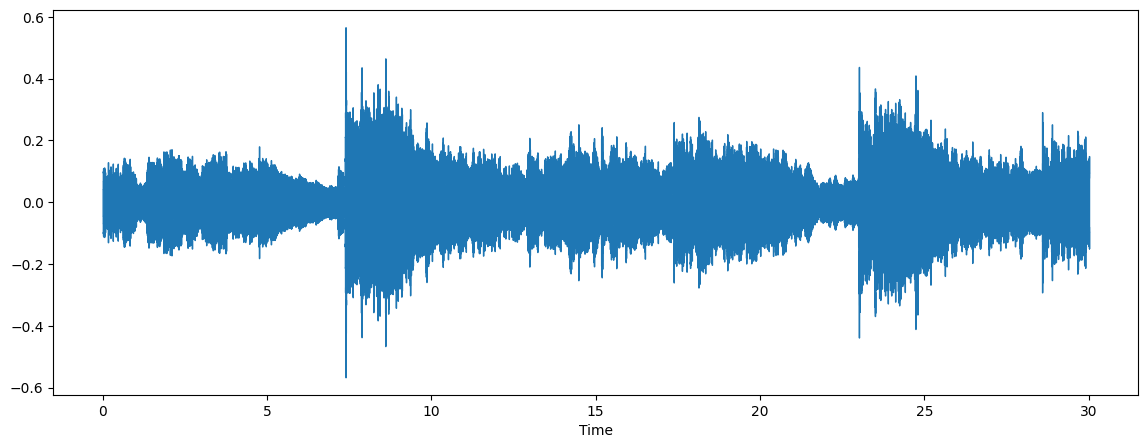

In [14]:
# plot of the amplitude envelope of a waveform using the audio array
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

A spectrogram is a visual representation of the spectrum of frequencies of sound over time.

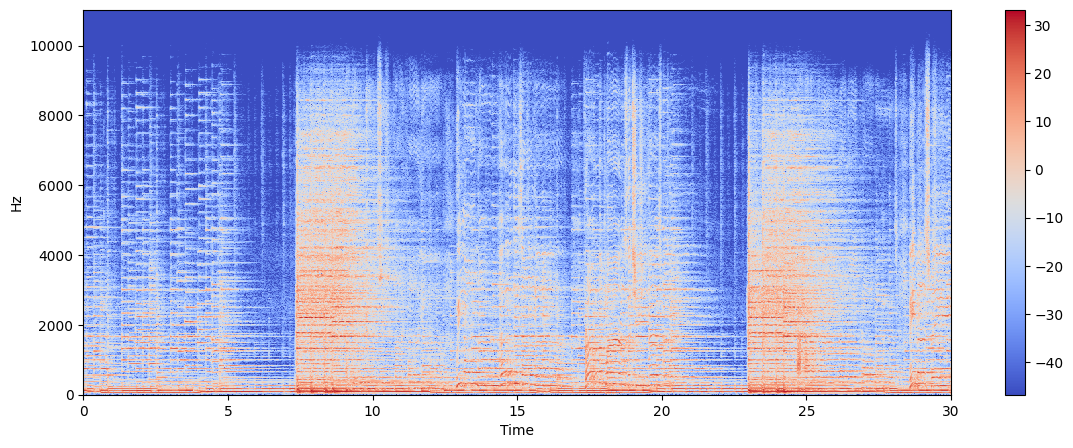

In [15]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
# Vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

A spectral centriod indicates where the "center of mass" for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. 

/tmp/ipykernel_1117/1597784081.py:7: FutureWarning: Pass y=[-0.02111816 -0.03451538 -0.03536987 ...  0.00134277  0.00250244
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


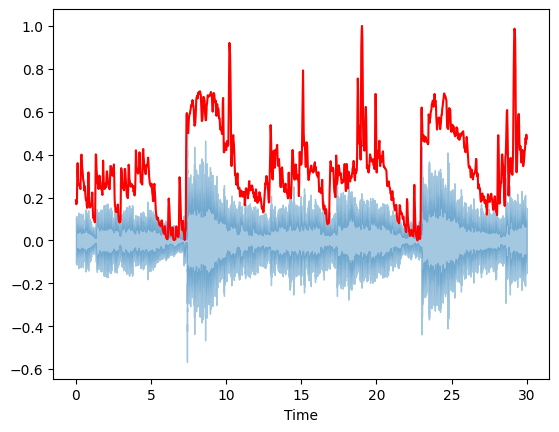

In [19]:
import sklearn

# Load the signal
x, sr = librosa.load('./Data/genres_original/rock/rock.00099.wav')


spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

Spectral Rolloff is a measure of the shape of the audio signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g., 85%, lies.

/tmp/ipykernel_1117/2403642598.py:1: FutureWarning: Pass y=[-0.01111816 -0.02451538 -0.02536987 ...  0.01134277  0.01250244
  0.00813843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]


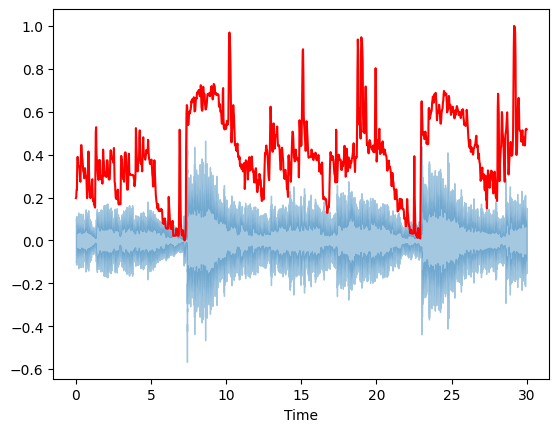

In [20]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) that concisely describe the overall shape of a spectral envelope. 

(20, 1293)


/tmp/ipykernel_1117/2337207193.py:1: FutureWarning: Pass y=[-0.02111816 -0.03451538 -0.03536987 ...  0.00134277  0.00250244
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=fs)


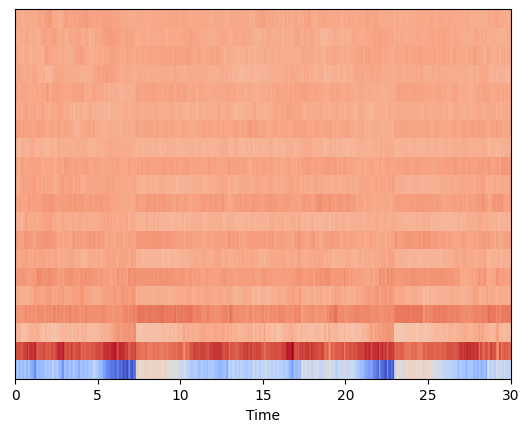

In [23]:
# computes MFCCs across an audio signal
x, fs = librosa.load('./Data/genres_original/rock/rock.00099.wav')
mfccs = librosa.feature.mfcc(x, sr=fs)
print (mfccs.shape)

#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

[ 0.0000000e+00  5.9005369e-09  5.9005369e-09  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  5.9005369e-09 -5.9005369e-09  0.0000000e+00 -8.8508054e-09
  5.9005369e-09 -2.9502685e-09  0.0000000e+00  1.1801074e-08]
[1.        1.        1.        1.0000001 1.        1.        1.
 1.        1.        1.0000001 1.0000001 1.0000001 1.        1.
 1.0000001 1.        1.0000001 1.        1.        1.0000001]


/home/mmgarcia/MidTerm/MidTerm/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/mmgarcia/MidTerm/MidTerm/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


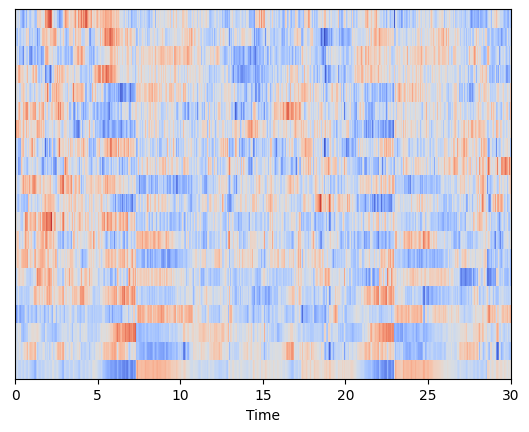

In [25]:
# perform feature scaling such that each coefficient dimension has zero mean and unit variance
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

Chroma frequencies project the entire spectrum onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

/tmp/ipykernel_1117/3733794312.py:2: FutureWarning: Pass y=[-0.02111816 -0.03451538 -0.03536987 ...  0.00134277  0.00250244
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)


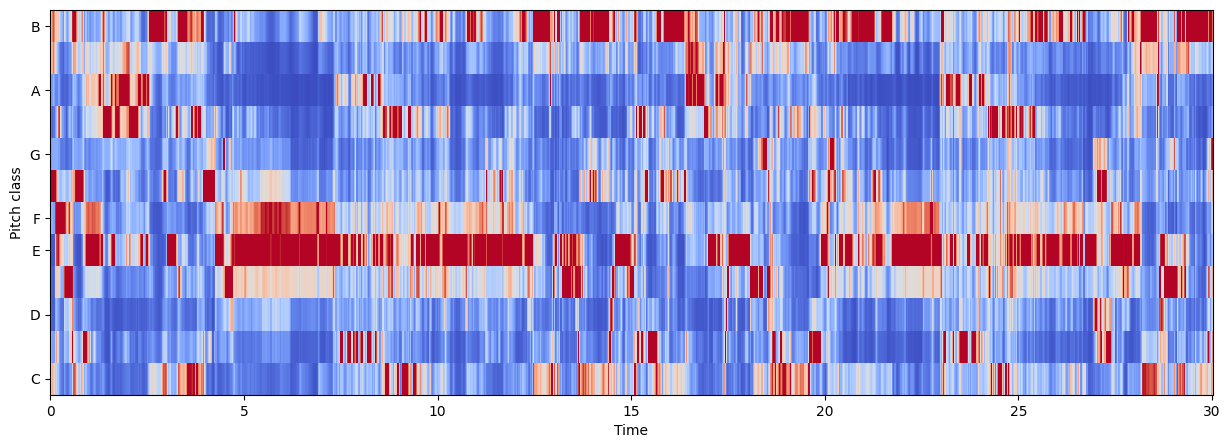

In [26]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

After implementing and training our KNN model and visualizing the resulting audio file in multiple ways we can check for the new data to check how much our model is compliant in predicting the new audio file. All the genres (or classes) are in numeric form, and we need to check the class name so first, we will implement a dictionary where the key is numeric label and value is the category name.

In [60]:
from collections import defaultdict
results = defaultdict(int)

directory = "./Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [62]:
#Predict a new audio file and receive a label for it and print the name of the category using the result dictionary.
pred = nearestclass(getNeighbors(dataset, feature, 5))
print(results[pred])

rock


### Test Two

In [27]:
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('mydataset.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.68, trainingSet, testSet)

In [28]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [29]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy2 = getAccuracy(testSet, predictions)
print(accuracy2)

1.0


In [30]:
print(folder)
print(file)

country
country.00013.wav


In [31]:
import librosa

audio_path2 = './Data/genres_original/country/country.00013.wav'
x , sr = librosa.load(audio_path2)

print(type(x), type(sr))

print(x.shape, sr)


<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [32]:
import IPython.display as ipd

# play audio clip
ipd.Audio(audio_path2)

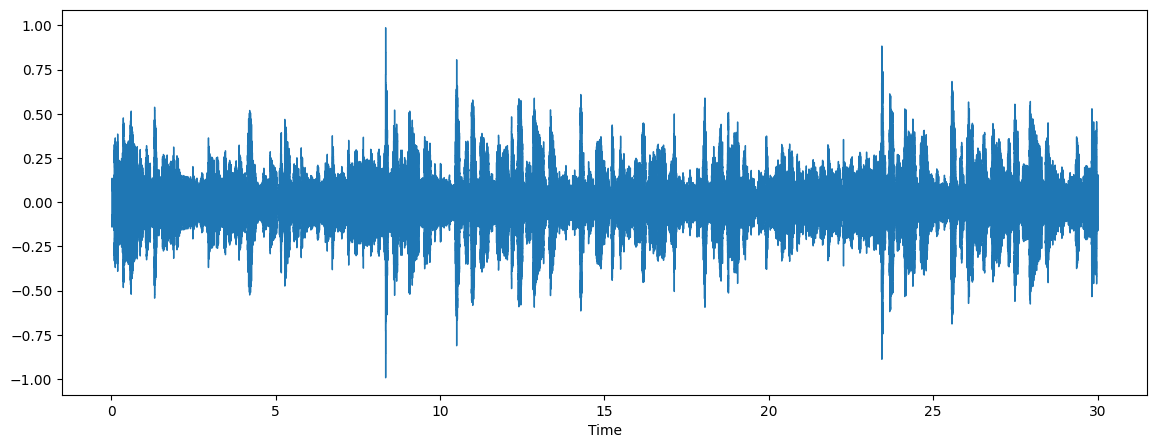

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

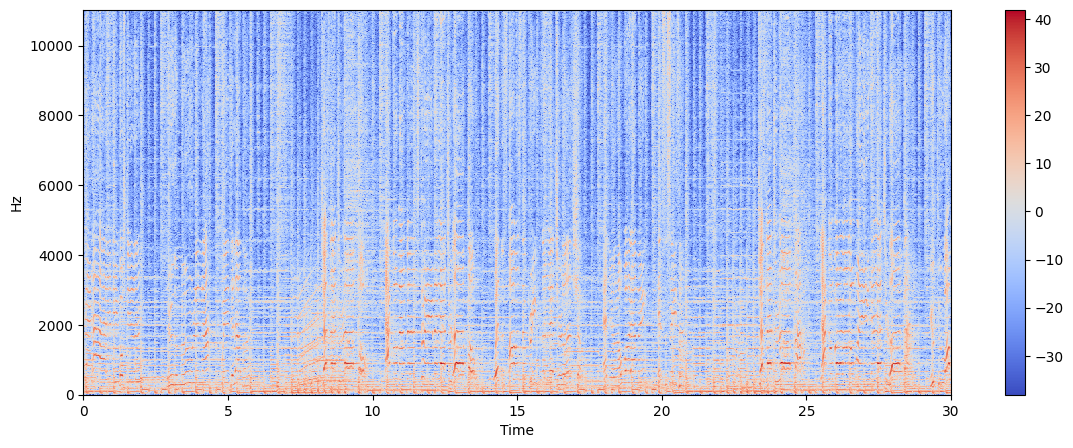

In [34]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

/tmp/ipykernel_1117/1302841509.py:7: FutureWarning: Pass y=[-0.03030396 -0.03936768 -0.04928589 ...  0.17648315  0.16107178
  0.12762451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


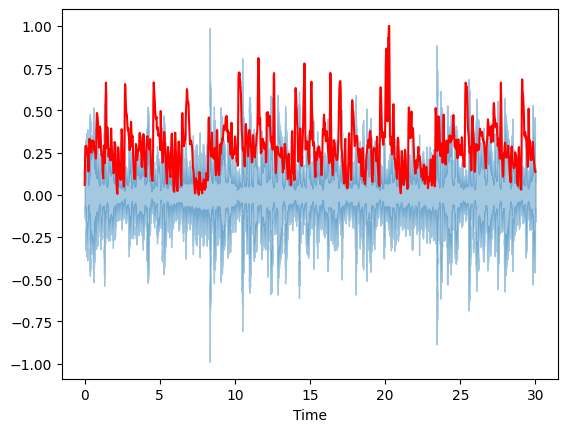

In [35]:
import sklearn

# Load the signal
x, sr = librosa.load('./Data/genres_original/country/country.00013.wav')


spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

/tmp/ipykernel_1117/2403642598.py:1: FutureWarning: Pass y=[-0.02030396 -0.02936768 -0.03928589 ...  0.18648316  0.17107178
  0.13762452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]


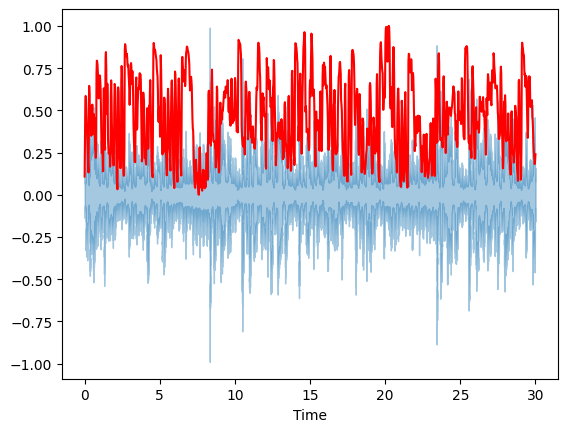

In [36]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 1293)


/tmp/ipykernel_1117/1139535965.py:2: FutureWarning: Pass y=[-0.03030396 -0.03936768 -0.04928589 ...  0.17648315  0.16107178
  0.12762451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=fs)


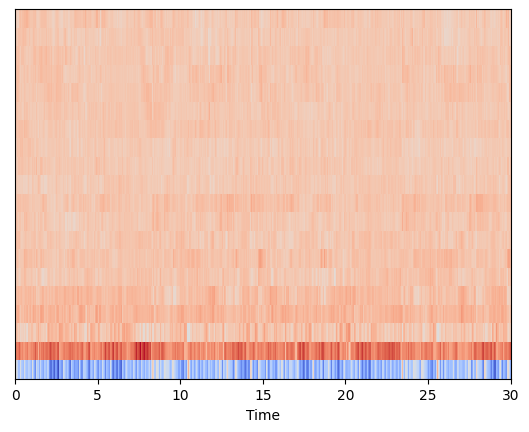

In [38]:
x, fs = librosa.load('./Data/genres_original/country/country.00013.wav')
mfccs = librosa.feature.mfcc(x, sr=fs)
print (mfccs.shape)

#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

[-1.1801074e-08 -8.8508054e-09  5.9005369e-09  0.0000000e+00
  0.0000000e+00 -2.9502685e-09  5.9005369e-09  0.0000000e+00
  0.0000000e+00  1.1801074e-08 -1.1801074e-08  0.0000000e+00
  0.0000000e+00  2.9502685e-09  0.0000000e+00  8.8508054e-09
  5.9005369e-09  1.1801074e-08  2.9502685e-09  2.9502685e-09]
[1.        0.9999999 0.9999998 1.0000001 1.        0.9999999 1.
 0.9999999 1.0000001 1.        1.        0.9999999 1.        1.
 0.9999998 1.        1.        0.9999999 1.0000002 1.       ]


/home/mmgarcia/MidTerm/MidTerm/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/mmgarcia/MidTerm/MidTerm/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


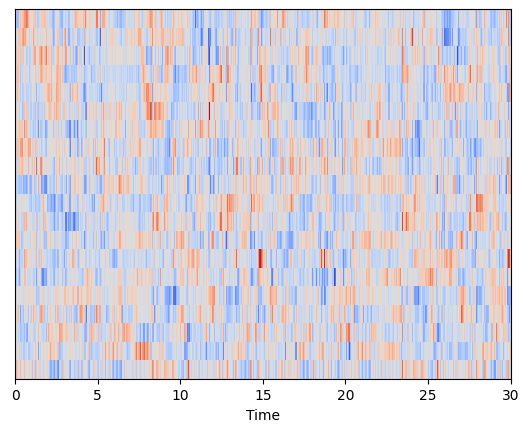

In [39]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

/tmp/ipykernel_1117/3733794312.py:2: FutureWarning: Pass y=[-0.03030396 -0.03936768 -0.04928589 ...  0.17648315  0.16107178
  0.12762451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)


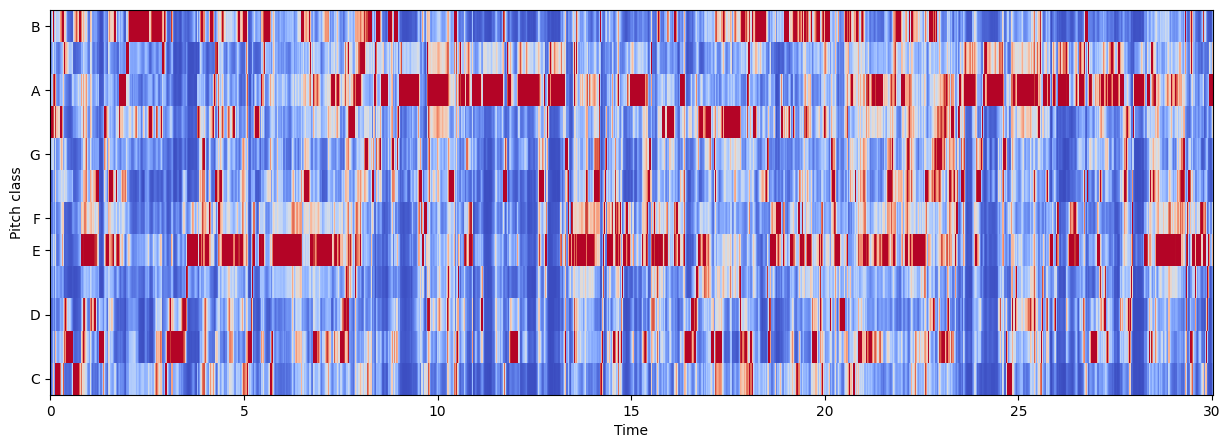

In [40]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

### Conclusion

I used MFCC to extract features from audio files then built a KNN classifier that finds K number of nearest neighbor based on features and maximum neighbor belonging to particular class (or musical genre) gives as an output. When we divide the audio files into different features such as amplitude and frequency and look at them over similar short spans of time we can observe that different genres have different common features. I visualized the audio frequency wave of amplitude and frequency with respect to time in form of a wave plot using librosa. 

MFCCs total provides 39 features related to frequency and amplitude, 12 parameters specifically related to the frequency amplitude. MFCC removes vocal excitation (pitch information) by dividing audio into frames, make extracted features independent, adjust the loudness, and frequency of sound according to humans, and capture the context. The difference in spectral patterns and waveplots between genres was especially obvious in our visualizations. 